In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
df_2014 = pd.read_csv("/Users/celestiq/Desktop/Programming/DataScience/datasets/US_stocks/2014_Financial_Data.csv")
df_2015 = pd.read_csv("/Users/celestiq/Desktop/Programming/DataScience/datasets/US_stocks/2015_Financial_Data.csv")
df_2016 = pd.read_csv("/Users/celestiq/Desktop/Programming/DataScience/datasets/US_stocks/2016_Financial_Data.csv")
df_2017 = pd.read_csv("/Users/celestiq/Desktop/Programming/DataScience/datasets/US_stocks/2017_Financial_Data.csv")
df_2018 = pd.read_csv("/Users/celestiq/Desktop/Programming/DataScience/datasets/US_stocks/2018_Financial_Data.csv")

In [5]:
df_2014.shape, df_2015.shape, df_2016.shape, df_2017.shape, df_2018.shape

((3808, 225), (4120, 225), (4797, 225), (4960, 225), (4392, 225))

<h1>EDA

Let's perform our analysis on 2018 dataset.

In [6]:
df_2018.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
0,CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,...,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1
1,KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,...,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1
2,INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,...,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1
3,MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,...,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1
4,GE,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,...,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1


<AxesSubplot:xlabel='Class', ylabel='count'>

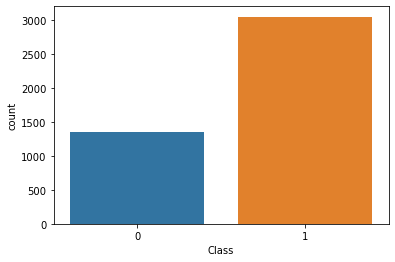

In [7]:
sns.countplot(df_2018["Class"])

Checking the null values...

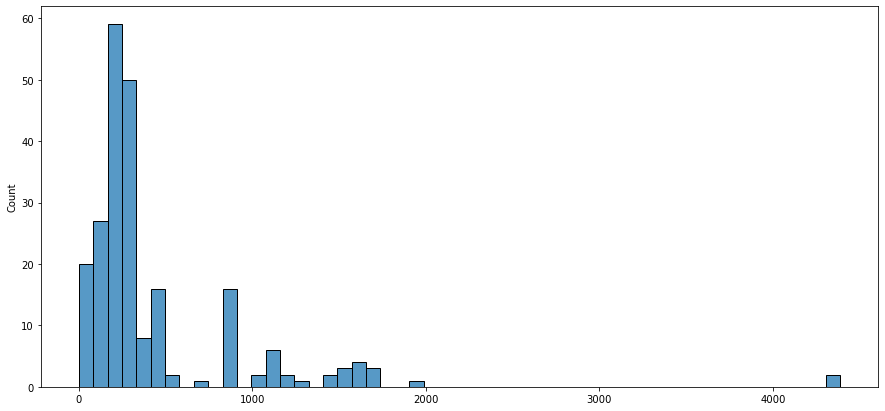

In [8]:
plt.figure(figsize=(15,7))
sns.histplot(df_2018.isnull().sum());

As we can see, there are a lot of null values involved. We will deal with them later on.

In [9]:
df_2018.dtypes.value_counts()

float64    222
object       2
int64        1
dtype: int64

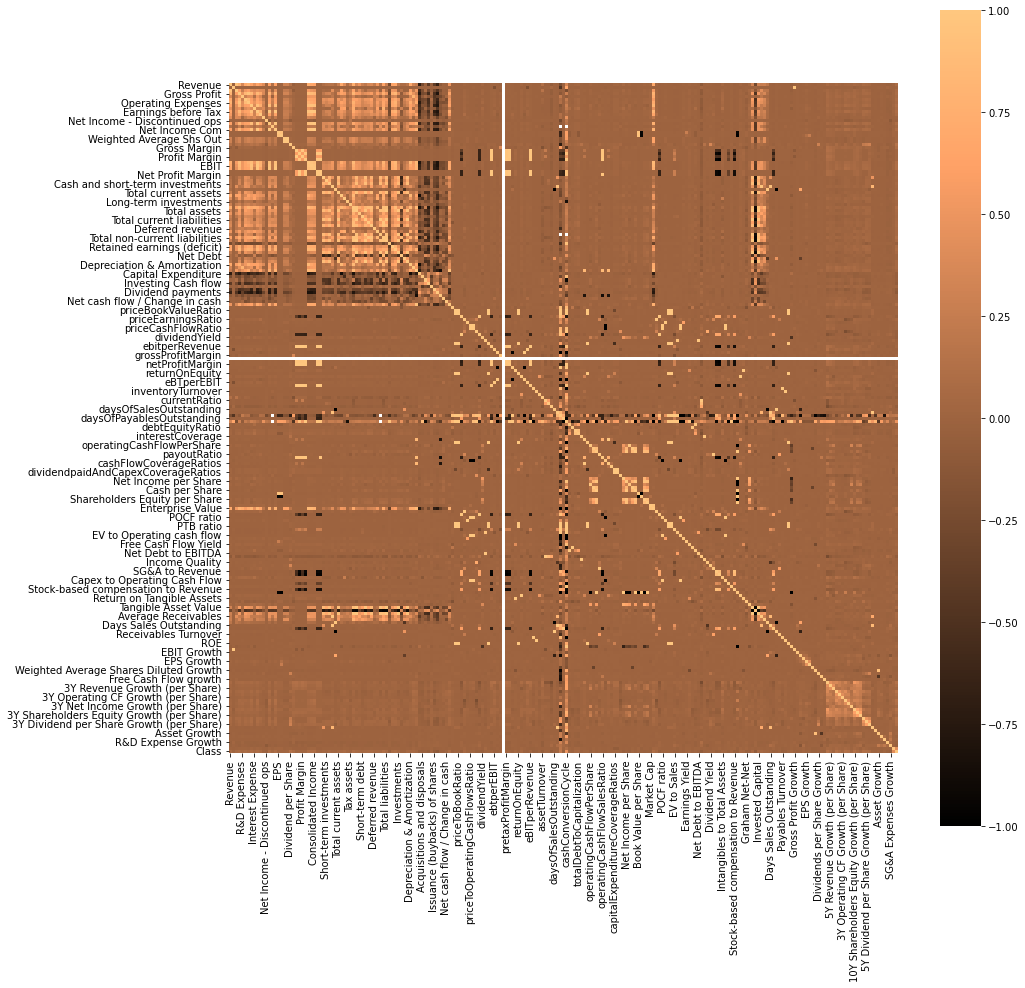

In [10]:
plt.figure(figsize=(15,15))
sns.heatmap(df_2018.corr(), square=True, cmap="copper");

We can see a quite some features that are highly correlated. We will get rid of them soon.

<h1>Preprocessing

First of all we will remove highly correlated features.

In [11]:
cor_matrix = df_2018.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype("bool"))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

In [12]:
df = df_2018.copy()
df = df.drop(to_drop, axis=1)

In [13]:
print("Number of features dropped: {}".format(df_2018.shape[1]-df.shape[1]))

Number of features dropped: 84


<h4>One Hot Encoding

In [14]:
df1 = df.drop(["Unnamed: 0"], axis=1).copy()

In [15]:
ohe = OneHotEncoder()
X_object = df1.select_dtypes('object')
ohe.fit(X_object)

codes = ohe.transform(X_object).toarray()
feature_names = ohe.get_feature_names_out()

df1 = pd.concat([df1.select_dtypes(exclude='object').reset_index(drop=True), pd.DataFrame(codes, columns=feature_names).astype(int)], axis=1)

<h4>Imputing Null Values

In [16]:
df1.isnull().sum().sort_values(ascending=False)

shortTermCoverageRatios                       1926
10Y Shareholders Equity Growth (per Share)    1695
dividendPayoutRatio                           1658
priceEarningsToGrowthRatio                    1658
10Y Revenue Growth (per Share)                1653
                                              ... 
Sector_Consumer Cyclical                         0
Sector_Basic Materials                           0
Class                                            0
2019 PRICE VAR [%]                               0
Sector_Utilities                                 0
Length: 150, dtype: int64

In [17]:
imputer = KNNImputer(n_neighbors=20, weights='distance', metric='nan_euclidean', copy=True)
columns = df1.columns
df1 = imputer.fit_transform(df1)
df1 = pd.DataFrame(df1, columns=columns)

In [18]:
df1.isnull().sum()

Revenue               0
Revenue Growth        0
Gross Profit          0
R&D Expenses          0
SG&A Expense          0
                     ..
Sector_Healthcare     0
Sector_Industrials    0
Sector_Real Estate    0
Sector_Technology     0
Sector_Utilities      0
Length: 150, dtype: int64

<h4>Standardisation

In [19]:
one_hot_features = ohe.get_feature_names_out()
columns_to_scale = [col for col in df1.drop(["Class", "2019 PRICE VAR [%]"], axis=1).columns if col not in one_hot_features]

In [20]:
X = df1.drop(["Class", "2019 PRICE VAR [%]"], axis=1)
y = df1["Class"]

In [21]:
X_scaler = MinMaxScaler()
X_scaler.fit(X[columns_to_scale])

scaled_X = X_scaler.transform(X[columns_to_scale])

X1 = pd.concat([pd.DataFrame(scaled_X, columns=columns_to_scale).astype(float), X[one_hot_features].reset_index(drop=True)], axis=1)

X1 = pd.DataFrame(X1, columns=X.columns)
y = np.array(y)

In [22]:
X1

,Revenue,Revenue Growth,Gross Profit,R&D Expenses,SG&A Expense,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,...,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,0.188996,0.000280,0.748069,0.003600,0.609115,0.392792,0.468054,0.389575,0.409619,0.187593,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.028402,0.000274,0.067365,0.003600,0.006949,0.214745,0.314407,0.253161,0.309822,0.212065,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.141717,0.000282,0.353785,0.471549,0.064605,0.443192,0.121239,0.476250,0.369743,0.169683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.060870,0.000311,0.153063,0.077578,0.008937,0.345808,0.165489,0.381040,0.294851,0.170093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.243168,0.000274,0.217234,0.003600,0.171131,0.000000,0.611488,0.000000,0.309679,0.145347,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,0.000138,0.000272,0.014120,0.003600,0.001349,0.170303,0.134198,0.229809,0.288809,0.169683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4388,0.000139,0.000239,0.014125,0.003765,0.001362,0.170238,0.133152,0.229869,0.288848,0.169683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4389,0.000247,0.000289,0.014262,0.003658,0.001380,0.170460,0.133269,0.230055,0.288898,0.169694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4390,0.000138,0.000272,0.014120,0.003957,0.001357,0.170152,0.133152,0.229790,0.288848,0.169683,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<h4>Selecting 20 best features

We will use sklearn's SelectKBest

In [23]:
selector = SelectKBest(chi2, k=20)
X_new = selector.fit_transform(X1.drop(one_hot_features, axis=1), y)
selector.get_feature_names_out()

array(['Revenue', 'Gross Profit', 'R&D Expenses', 'SG&A Expense',
       'Dividend per Share', 'Cash and cash equivalents',
       'Cash and short-term investments', 'Total current assets',
       'Property, Plant & Equipment Net',
       'Goodwill and Intangible Assets', 'Long-term investments',
       'Total non-current assets', 'Total debt', 'Deferred revenue',
       'Depreciation & Amortization', 'priceToSalesRatio',
       'dividendYield', 'cashRatio', 'Revenue per Share',
       'Weighted Average Shares Growth'], dtype=object)

In [24]:
X_new = pd.DataFrame(X_new, columns=selector.get_feature_names_out())
X_new

,Revenue,Gross Profit,R&D Expenses,SG&A Expense,Dividend per Share,Cash and cash equivalents,Cash and short-term investments,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Total non-current assets,Total debt,Deferred revenue,Depreciation & Amortization,priceToSalesRatio,dividendYield,cashRatio,Revenue per Share,Weighted Average Shares Growth
0,0.188996,0.748069,0.003600,0.609115,0.020241,3.860324e-03,3.944157e-03,0.018499,0.179833,5.718423e-01,0.008002,0.478389,0.221729,0.043058,0.318588,0.000104,0.000058,0.001006,9.905518e-08,0.000002
1,0.028402,0.067365,0.003600,0.006949,0.016003,3.319838e-03,3.391934e-03,0.004845,0.153366,8.475819e-02,0.007598,0.152245,0.084445,0.000000,0.069134,0.000153,0.000130,0.003159,3.544672e-08,0.000002
2,0.141717,0.353785,0.471549,0.064605,0.026487,3.055668e-03,1.204757e-02,0.024375,0.198202,1.240038e-01,0.009557,0.206429,0.064217,0.000000,0.271222,0.000193,0.000069,0.001321,7.515057e-08,0.000002
3,0.060870,0.153063,0.077578,0.008937,0.000000,6.585020e-03,7.034126e-03,0.013581,0.095799,5.318496e-03,0.000556,0.056900,0.024149,0.000000,0.142431,0.000128,0.000000,0.008228,1.238443e-07,0.000003
4,0.243168,0.217234,0.003600,0.171131,0.008167,3.150202e-02,6.717580e-02,0.097966,0.176491,1.574466e-01,0.000383,0.199071,0.206707,0.374595,0.245589,0.000033,0.000190,0.003364,6.903650e-08,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,0.000138,0.014120,0.003600,0.001349,0.000000,1.222632e-07,1.257446e-07,0.000040,0.001518,0.000000e+00,0.000080,0.000300,0.015808,0.000000,0.000750,0.000000,0.000000,0.000015,7.233709e-09,0.000004
4388,0.000139,0.014125,0.003765,0.001362,0.000000,3.395749e-06,6.309204e-06,0.000005,0.000025,0.000000e+00,0.000080,0.000014,0.015603,0.000000,0.000756,0.000953,0.000000,0.014878,7.481242e-09,0.000011
4389,0.000247,0.014262,0.003658,0.001380,0.000000,7.775900e-06,9.253123e-06,0.000054,0.000025,3.200721e-06,0.000080,0.000025,0.015627,0.000000,0.000762,0.000049,0.000000,0.001429,2.505873e-08,0.000003
4390,0.000138,0.014120,0.003957,0.001357,0.000000,1.963831e-06,2.006479e-06,0.000003,0.000003,4.454709e-08,0.000080,0.000005,0.015591,0.000000,0.000756,0.000000,0.000000,0.005941,7.233709e-09,0.000003


In [25]:
X2 = pd.concat([X_new.reset_index(drop=True), X1[one_hot_features].reset_index(drop=True)], axis=1)
X2

,Revenue,Gross Profit,R&D Expenses,SG&A Expense,Dividend per Share,Cash and cash equivalents,Cash and short-term investments,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,...,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,0.188996,0.748069,0.003600,0.609115,0.020241,3.860324e-03,3.944157e-03,0.018499,0.179833,5.718423e-01,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.028402,0.067365,0.003600,0.006949,0.016003,3.319838e-03,3.391934e-03,0.004845,0.153366,8.475819e-02,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.141717,0.353785,0.471549,0.064605,0.026487,3.055668e-03,1.204757e-02,0.024375,0.198202,1.240038e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.060870,0.153063,0.077578,0.008937,0.000000,6.585020e-03,7.034126e-03,0.013581,0.095799,5.318496e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.243168,0.217234,0.003600,0.171131,0.008167,3.150202e-02,6.717580e-02,0.097966,0.176491,1.574466e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,0.000138,0.014120,0.003600,0.001349,0.000000,1.222632e-07,1.257446e-07,0.000040,0.001518,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4388,0.000139,0.014125,0.003765,0.001362,0.000000,3.395749e-06,6.309204e-06,0.000005,0.000025,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4389,0.000247,0.014262,0.003658,0.001380,0.000000,7.775900e-06,9.253123e-06,0.000054,0.000025,3.200721e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4390,0.000138,0.014120,0.003957,0.001357,0.000000,1.963831e-06,2.006479e-06,0.000003,0.000003,4.454709e-08,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<h1>Modeling

In [92]:
x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size=0.1)

In [93]:
models = [DecisionTreeClassifier(), ExtraTreeClassifier(), AdaBoostClassifier(), RandomForestClassifier(), LogisticRegression(), RidgeClassifier(), KNeighborsClassifier(), GaussianNB(), GradientBoostingClassifier()]
score = {}

for model in models:
    print("---------------")
    print("Training model: " + str(model))
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    result = accuracy_score(y_test, y_preds)
    score[str(model)] = round(result, 4)
    print(str(model) + " Performance: " + str(round(result,4)))

---------------
Training model: DecisionTreeClassifier()
DecisionTreeClassifier() Performance: 0.6659
---------------
Training model: ExtraTreeClassifier()
ExtraTreeClassifier() Performance: 0.6545
---------------
Training model: AdaBoostClassifier()
AdaBoostClassifier() Performance: 0.7432
---------------
Training model: RandomForestClassifier()
RandomForestClassifier() Performance: 0.7386
---------------
Training model: LogisticRegression()
LogisticRegression() Performance: 0.6705
---------------
Training model: RidgeClassifier()
RidgeClassifier() Performance: 0.6773
---------------
Training model: KNeighborsClassifier()
KNeighborsClassifier() Performance: 0.6909
---------------
Training model: GaussianNB()
GaussianNB() Performance: 0.5818
---------------
Training model: GradientBoostingClassifier()
GradientBoostingClassifier() Performance: 0.7409


(0.25, 0.7803599999999999)

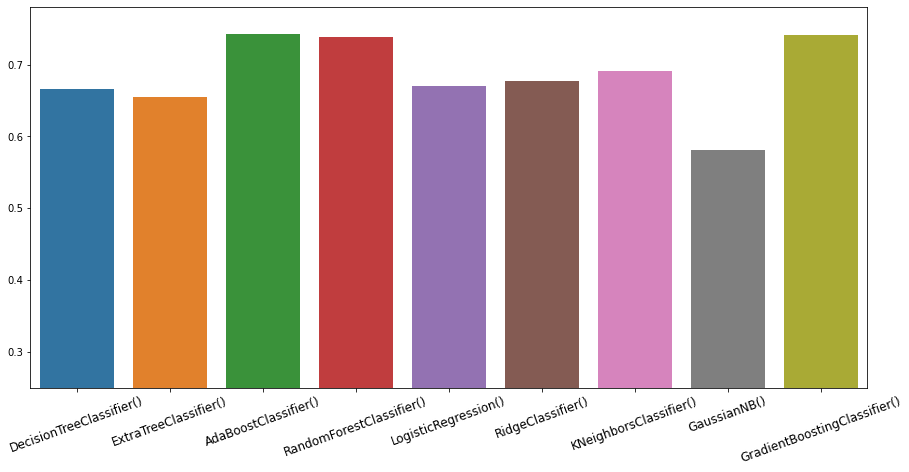

In [94]:
plt.figure(figsize=(15,7))
sns.barplot(x=list(score.keys()), y=list(score.values()))
plt.xticks(fontsize=12, rotation=20);
plt.ylim(0.25)

AdaBoost, RandomForest and GradientBoosting Classifiers performed almost equally well. Let's analyse other metrics.

In [95]:
better_models = [AdaBoostClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
model_performance = []
for model in better_models:
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    performance = {}
    performance["Model"] = str(model)
    performance["Accuracy"] = accuracy_score(y_test, y_preds)
    performance["F1-Score"] = f1_score(y_test, y_preds)
    performance["Precision"] = precision_score(y_test, y_preds)
    performance["Recall"] = recall_score(y_test, y_preds)
    model_performance.append(performance)

model_performance = pd.DataFrame(model_performance)

In [96]:
model_performance

,Model,Accuracy,F1-Score,Precision,Recall
0,AdaBoostClassifier(),0.743182,0.826953,0.771429,0.891089
1,RandomForestClassifier(),0.747727,0.832579,0.766667,0.910891
2,GradientBoostingClassifier(),0.740909,0.826748,0.766197,0.897690


<AxesSubplot:xlabel='Model'>

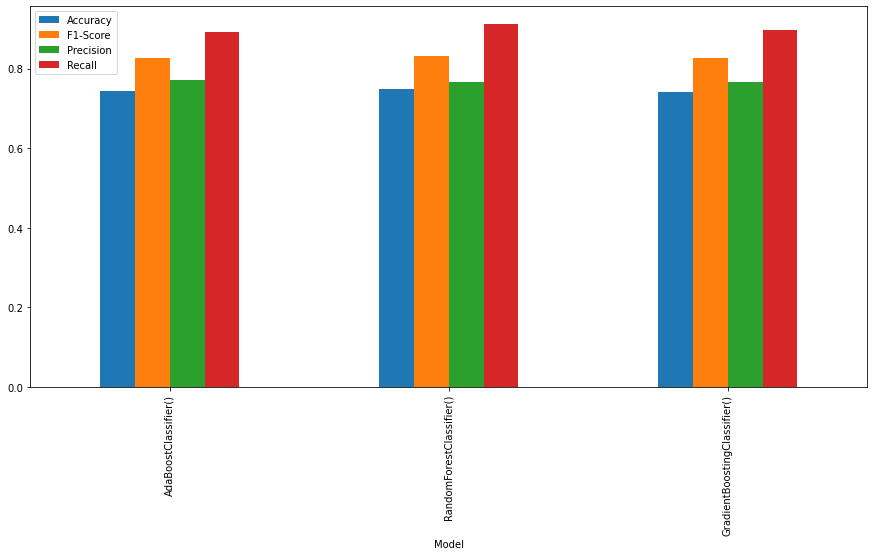

In [108]:
model_performance.plot(x="Model", y=["Accuracy", "F1-Score", "Precision", "Recall"], kind="bar", figsize=(15,7))